# Notebook 02: Modelo de Riesgo (GPD) y Stock de Seguridad (por Producto)
## Objetivo: Calcular el stock de seguridad óptimo basándonos en los errores (residuos) del modelo core (GBR), aplicando un modelo de riesgo individual para cada producto.

## Metodología:

- Cargar los resultados de validación (reales vs. predicción) del 01-model_core.ipynb.

- Calcular los residuos (Error = Real - Predicción).

- Iterar por cada prod_id único:

    - Aislar sus residuos positivos (quiebres de stock).

    - Definir un umbral (Cuantil 90%) para ese producto.

    - Ajustar un modelo GPD a los "excesos" de ese producto.

    - Calcular el stock de seguridad para un Nivel de Servicio (NS) del 98%.

- Guardar el mapeo final (prod_id -> stock_de_seguridad) en data/processed/.

## 0. Configuración e Importación

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import genpareto
import warnings

# Configuración de visualización
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 7)

# Ignorar advertencias de convergencia de 'fit' que pueden ocurrir
# si un producto tiene datos de cola muy escasos.
warnings.filterwarnings('ignore', category=RuntimeWarning)

## 1. Carga de Datos (Resultados del Modelo Core)
Cargamos el archivo .csv que generó el notebook 01-model_core.ipynb desde la carpeta data/interim/.

In [2]:
# Cargar los resultados del notebook anterior
path_datos = '../data/interim/model_core_validation.csv'
val_comparativo = pd.read_csv(path_datos)

print("Datos de validación (input) cargados:")
print(f"Filas cargadas: {len(val_comparativo)}")
print(val_comparativo.head())

Datos de validación (input) cargados:
Filas cargadas: 7620
        fecha  prod_id  precio_promedio  ventas  modelo_actual  year  month  \
0  2023-01-01        0      5718.490738  2447.0    1662.504452  2023      1   
1  2023-02-01        0      6718.343539  1565.0    1692.611786  2023      2   
2  2023-03-01        0      5742.707352   786.0    1545.866974  2023      3   
3  2023-04-01        0      5267.384648   775.0    1340.509092  2023      4   
4  2023-05-01        0      4020.565431  1063.0    1138.194231  2023      5   

   lag_12  lag_13  lag_24  rolling_mean_3_lag12  precio_lag_12     pred_gbr  
0  2121.0  1019.0  4488.0           1410.000000    4085.525083  2111.058526  
1   924.0  2121.0  1512.0           1354.666667    6603.793792  1230.176206  
2  1678.0   924.0  1379.0           1574.333333    3723.599803  1247.068278  
3   565.0  1678.0  1457.0           1055.666667    6393.080571  1090.714359  
4   559.0   565.0  1178.0            934.000000    5802.376341   924.195118 

## 2. Calcular y Analizar Residuos
Calculamos el error de nuestro modelo core. Residuo = Venta_Real - Predicción_GBR

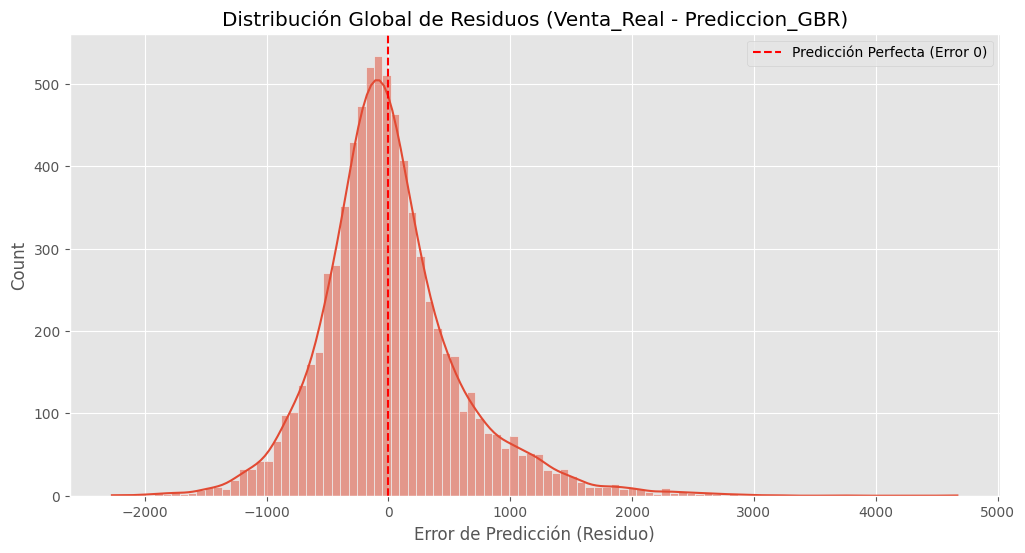

In [3]:
# Calcular residuos
val_comparativo['residuo'] = val_comparativo['ventas'] - val_comparativo['pred_gbr']

# Graficar la distribución de los residuos (visión global)
plt.figure(figsize=(12, 6))
sns.histplot(val_comparativo['residuo'], kde=True, bins=100)
plt.title('Distribución Global de Residuos (Venta_Real - Prediccion_GBR)')
plt.xlabel('Error de Predicción (Residuo)')
plt.axvline(0, color='red', linestyle='--', label='Predicción Perfecta (Error 0)')
plt.legend()
plt.show()

## 3. Calcular Stock de Seguridad por Producto (GPD)
Este es el núcleo del notebook. En lugar de un GPD global, iteramos sobre cada producto y calculamos su perfil de riesgo individual.

In [4]:
# --- CÁLCULO DE GPD POR PRODUCTO ---

# Nivel de servicio objetivo (cuánta demanda queremos cubrir)
NIVEL_SERVICIO_OBJETIVO = 0.98
CUANTIL_UMBRAL = 0.90 # Umbral en el 90% de los errores positivos

# 1. Crear un diccionario para guardar el stock de seguridad de cada producto
stock_seguridad_por_producto = {}

# 2. Iterar sobre cada producto
productos_unicos = val_comparativo['prod_id'].unique()
print(f"Iniciando cálculo de GPD para {len(productos_unicos)} productos...")

for pid in productos_unicos:
    df_prod = val_comparativo[val_comparativo['prod_id'] == pid]
    
    # Aislar residuos positivos para este producto
    residuos_pos = df_prod[df_prod['residuo'] > 0]['residuo']
    
    # Default: si no hay errores positivos, el stock de seguridad es 0
    stock_de_seguridad = 0
    
    # 3. Verificar si tenemos suficientes datos para el GPD
    if not residuos_pos.empty:
        
        # 4. Calcular umbral para este producto
        umbral = residuos_pos.quantile(CUANTIL_UMBRAL)
        
        # Fallback: si el umbral es 0 (todos los errores son pequeños), usar el cuantil 98%
        if umbral <= 0:
            stock_de_seguridad = residuos_pos.quantile(NIVEL_SERVICIO_OBJETIVO)
        else:
            excesos = residuos_pos[residuos_pos > umbral] - umbral
            
            # 5. Ajustar GPD (solo si hay excesos sobre el umbral)
            if not excesos.empty:
                try:
                    c, loc, scale = genpareto.fit(excesos, floc=0)
                    
                    # 6. Calcular stock de seguridad para este producto
                    prob_gpd = (NIVEL_SERVICIO_OBJETIVO - CUANTIL_UMBRAL) / (1 - CUANTIL_UMBRAL)
                    stock_extra_gpd = genpareto.ppf(prob_gpd, c, loc=loc, scale=scale)
                    
                    stock_de_seguridad = umbral + stock_extra_gpd
                except Exception as e:
                    # Si GPD falla (datos inestables), usar el cuantil 98% como fallback seguro
                    stock_de_seguridad = residuos_pos.quantile(NIVEL_SERVICIO_OBJETIVO)
            else:
                # Si no hay excesos (datos muy estables), usar el cuantil 98%
                stock_de_seguridad = residuos_pos.quantile(NIVEL_SERVICIO_OBJETIVO)
            
    # Guardar el valor (redondeado y asegurando que no sea NaN o infinito)
    stock_de_seguridad = np.nan_to_num(stock_de_seguridad)
    stock_seguridad_por_producto[pid] = np.round(stock_de_seguridad)

print(f"Cálculo de stock de seguridad completado.")

# Ver ejemplos
print("\n--- Ejemplos de Stock de Seguridad (por producto) ---")
for i, (pid, stock) in enumerate(stock_seguridad_por_producto.items()):
    if i < 5:
        print(f"Producto {pid}: {stock:.0f} unidades")

Iniciando cálculo de GPD para 635 productos...
Cálculo de stock de seguridad completado.

--- Ejemplos de Stock de Seguridad (por producto) ---
Producto 0: 1089 unidades
Producto 1: 970 unidades
Producto 3: 1220 unidades
Producto 4: 1108 unidades
Producto 6: 119 unidades


## 4. Guardar Resultados del Modelo de Riesgo
Guardamos el mapeo de prod_id -> stock_de_seguridad en la carpeta data/processed/. Este será el input para nuestro notebook final de reporte.

In [5]:
import json

# Convertir el diccionario a un DataFrame para guardarlo
df_stock_seguridad = pd.DataFrame(list(stock_seguridad_por_producto.items()), 
                                  columns=['prod_id', 'stock_de_seguridad'])

# Definir la ruta de salida
path_salida_riesgo = '../data/processed/stock_seguridad_por_producto.csv'

# Guardar el DataFrame
df_stock_seguridad.to_csv(path_salida_riesgo, index=False)

print(f"Mapeo de stock de seguridad guardado en: {path_salida_riesgo}")
print(df_stock_seguridad.head())

Mapeo de stock de seguridad guardado en: ../data/processed/stock_seguridad_por_producto.csv
   prod_id  stock_de_seguridad
0        0              1089.0
1        1               970.0
2        3              1220.0
3        4              1108.0
4        6               119.0


## 5. Próximos Pasos
Este notebook está completo. Ha generado el perfil de riesgo para cada producto.

Próximo Notebook: 03-model_inference.ipynb, que generará el pronóstico base para 2024.

Notebook Final: 04-generar_reporte_final.ipynb, que unirá la salida de este notebook (riesgo) con la del notebook 03 (pronóstico) para crear la política de inventario final.